In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.image as mpimg
import glob



In [2]:
def read_data():
	input_image = []
	i = 0
	for filename in glob.iglob('../data/tiny-imagenet-200/train/**/*.JPEG',recursive=True):
		img = mpimg.imread(filename)
		if(img.shape == (64,64,3)):
			input_image.append(list(mpimg.imread(filename)))
		if(i%10000 == 0):
			print(i)
		i+=1
		#if(i>5000):
		#	break

	return np.asarray(input_image)

In [3]:
image_data = read_data()
print (image_data.shape)




0
10000
20000
30000
40000
50000
60000
70000
80000
90000
(98179, 64, 64, 3)


Here


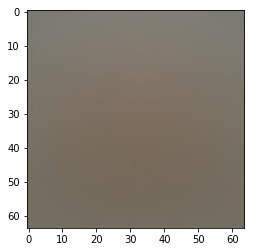

In [4]:
import matplotlib.pyplot as plt
mean_image = np.mean(image_data,axis = 0,dtype = 'float32')
print ("Here")
image_data = image_data- mean_image
plt.imshow(mean_image.astype('uint8'))
plt.show()

In [5]:
### Converting RGB TO GRAYSCALE DEMO MODEL

def simple_rgb_to_gray(X,Y):
	Wconv1 = tf.get_variable("Wconv1", shape=[1, 1, 3, 1])
	bconv1 = tf.get_variable("bconv1", shape=[1])
	y_out = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME')
	#y_out = y_out[:,:,:,0]
	return y_out

def rgb2gray(rgb):
    a = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return a[:,:,:,np.newaxis]


In [6]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 64, 64, 3])
Y = tf.placeholder(tf.float32 ,[None , 64,64,1])
y_out = simple_rgb_to_gray(X,Y)
loss = tf.nn.l2_loss(y_out - Y)
optimiser = tf.train.AdamOptimizer(0.4)
train_step = optimiser.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


for i in range(600):
    
	feed_dict = {X: image_data[i*100:100*i+100], Y: rgb2gray(image_data[i*100:i*100+100])}
	losses,_ = sess.run([loss,train_step],feed_dict)
	if(i%50 ==0):
		print (losses)

7.29879e+09
3.42741e+07
199325.0
358.674
3.52261
0.0160818
0.000889551
6.18149e-06
2.14312e-06
1.68693e-06
1.98715e-06
2.18504e-06


In [7]:
var  = tf.trainable_variables()
var = [v.name for v in tf.trainable_variables() ]
print (var)
numpy_val = sess.run([var[0]])
weights = np.asarray(numpy_val[0])
print (weights)

print ("Observe that weights are close to [0.299,0.587,0.114] , hence it learns rgb to gray conversion")

['Wconv1:0', 'bconv1:0']
[[[[ 0.29900002]
   [ 0.58699995]
   [ 0.11400003]]]]
Observe that weights are close to [0.299,0.587,0.114] , hence it learns rgb to gray conversion


In [8]:
def baselinish(X,Y,is_training):
    
    W_conv = tf.get_variable("Wconv",shape = [3,3,1,32])
    b_conv = tf.get_variable("bconv",shape = [32])
    a1 = tf.nn.conv2d(X, W_conv, strides=[1,1,1,1], padding='SAME') + b_conv
    a1 = tf.nn.relu(a1)
    #a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn1')
    #a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    W_conv2 = tf.get_variable("Wconv2",shape = [3,3,32,64])
    b_conv2 = tf.get_variable("bconv2",shape = [64])
    a1 = tf.nn.conv2d(a1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
    a1 = tf.nn.relu(a1)
    #a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn2')
    
    W_conv3 = tf.get_variable("Wconv3",shape = [3,3,64,3])
    b_conv3 = tf.get_variable("bconv3",shape = [3])
    a1 = tf.nn.conv2d(a1, W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3
    
    return a1
    
    #a1 = tf.nn.relu(a1)
    #a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn3')
    
    


In [9]:

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 64, 64,1])
Y = tf.placeholder(tf.float32 ,[None , 64,64,3])
is_training = True;
y_out = baselinish(X,Y,is_training)
loss = tf.nn.l2_loss(y_out - Y)
optimiser = tf.train.AdamOptimizer(0.1)
train_step = optimiser.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


for i in range(1):
    
	feed_dict = {Y: image_data[i*100:100*i+100], X: rgb2gray(image_data[i*100:i*100+100])}
	losses,_ = sess.run([loss,train_step],feed_dict)
	if(i%5 ==0):
		print (losses)

2.82477e+09


In [ ]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 64, 64,1])
Y = tf.placeholder(tf.float32 ,[None , 64,64,3])
is_training = tf.placeholder(tf.bool)
with tf.variable_scope("model") as scope:
    train_model = baselinish(X,Y,is_training)
    loss = tf.nn.l2_loss(train_model-Y)
    optimiser = tf.train.AdamOptimizer(0.01)
    train_step = optimiser.minimize(loss)

    scope.reuse_variables()
    test_model = baselinish(X,Y,is_training)
    loss_test = tf.nn.l2_loss(test_model - Y)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

X_small_train = image_data[0:60000]
X_small_test = image_data[60000:70000]

def train_epoch(data):
    sizee = data.shape[0]
    batch_size = 100
    for i in range(sizee//batch_size):
        feed_dict = {Y: data[i*batch_size:batch_size*i+batch_size], X: rgb2gray(data[i*batch_size:batch_size*i+batch_size]),is_training:True}
        losses,_ = sess.run([loss,train_step],feed_dict)
        if(i%5==0):
            print (losses)

  

def val_result(data):
    sizee = data.shape[0]
    batch_size = 100
    for i in range(sizee//batch_size):
        feed_dict = {Y: data[i*batch_size:batch_size*i+batch_size], X: rgb2gray(data[i*batch_size:batch_size*i+batch_size]),is_training:False}
        losses = sess.run([loss_test],feed_dict)
        if(i%5 ==0):
            print (losses)

num_epochs = 2
for i in range(num_epochs):
    train_epoch(X_small_train)
    val_result(X_small_test)

    



3.11436e+09
8.53017e+08
4.20555e+08
3.62706e+08
3.05249e+08
3.15915e+08
2.32528e+08
3.86798e+08
2.72259e+08
2.19203e+08
3.26696e+08
2.43652e+08
1.70487e+08
2.21264e+09
9.32889e+08
6.44976e+08
3.43498e+08
3.82208e+08
5.84535e+08
4.65194e+08
2.42241e+08
2.81215e+08
3.12711e+08
1.07634e+09
8.40695e+08
3.66514e+08
2.97062e+08
3.07445e+08
2.42532e+08
2.1803e+08
1.97032e+08
1.92416e+08
1.7182e+08
1.36665e+08
2.23089e+08
2.45123e+08
6.01583e+08
6.76351e+08
8.45727e+08
4.71946e+08
3.90021e+08
3.38588e+08
3.86434e+08
4.10379e+08
5.85703e+08
6.93059e+08
6.12982e+08
4.26819e+08
2.00008e+08
2.29568e+08
2.39413e+08
1.74989e+08


In [ ]:
### Image visualisation
import matplotlib.pyplot as plt
import numpy.random as rnd

def rgb2gray2(rgb):
    a = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return a

rand_indices = np.random.choice(2000,10)
sample_images = X_small_train[rand_indices]
print (sample_images.shape)
grayed_sample_images = rgb2gray2(sample_images)
print (grayed_sample_images.shape)

feed_dict = {X:grayed_sample_images[:,:,:,np.newaxis],Y:sample_images,is_training:True}
model_generated_images = sess.run([test_model,loss_test],feed_dict)
print (model_generated_images[1])
print(model_generated_images[0].shape)

def show_images(images,gray = False):

    
    if(gray):
        plt.subplot(221)
        plt.imshow(images[0],cmap = plt.get_cmap('gray'))
        plt.subplot(222)
        plt.imshow(images[1], cmap = plt.get_cmap('gray'))
        plt.subplot(223)
        plt.imshow(images[2], cmap = plt.get_cmap('gray'))
        plt.subplot(224)
        plt.imshow(images[3], cmap = plt.get_cmap('gray'))
    else :
        plt.subplot(221)
        plt.imshow(images[0]);
        plt.subplot(222)
        plt.imshow(images[1])
        plt.subplot(223)
        plt.imshow(images[2])
        plt.subplot(224)
        plt.imshow(images[3])

    plt.show()
    
    
show_images((sample_images+mean_image))
show_images(grayed_sample_images + mean_image,gray = True)
show_images(model_generated_images[0] + mean_image)

    